# 02 - ML experimentation with a custom model

The purpose of this notebook is to to train a custom `TF.keras` classifier model to predict whether a given trip will result in a tip > 20%. The notebook covers the following tasks:

1. Preprocess the data locally using Apache Beam.
2. Train and test the trained custom model locally.
3. Submit a `Dataflow` job to preprocess the data at scale.
4. Submit a custom training job to `Vertex AI` training service using a prebuilt container.
5. Upload the trained model as a `Vertex Model` resource.
6. Track experiment parameters from `Vertex ML Metadata`

The notebook uses `Vertex TensorBoard` and `Vertex ML Metadata` to  track, visualize, and compare ML experiments.

Learn about [custom training](https://cloud.google.com/ai-platform-unified/docs/training/custom-training).

Learn about [pre-built container](https://cloud.google.com/ai-platform-unified/docs/training/pre-built-containers).

Learn about [Vertex TensorBoard](https://cloud.google.com/vertex-ai/docs/experiments/tensorboard-overview).

Learn about [Vertex ML Metadata](https://cloud.google.com/vertex-ai/docs/ml-metadata/introduction).

## Setup

### Import libraries

In [1]:
import os
import time
import logging
from datetime import datetime
import numpy as np

import tensorflow as tf
import tensorflow_transform as tft
import tensorflow.keras as keras

from google.cloud import aiplatform as vertex_ai
from google.cloud import aiplatform_v1beta1 as vertex_ai_beta

from src.common import features, datasource_utils
from src.model_training import data, model, defaults, trainer, exporter
from src.preprocessing import etl

logging.getLogger().setLevel(logging.INFO)
tf.get_logger().setLevel('INFO')

print(f"TensorFlow: {tf.__version__}")
print(f"TensorFlow Transform: {tft.__version__}")

INFO:apache_beam.typehints.native_type_compatibility:Using Any for unsupported type: typing.Sequence[~T]
TensorFlow: 2.4.2
TensorFlow Transform: 0.30.0


### Setup Google Cloud project

In [13]:
PROJECT_ID = '[your-project-id]' # Change to your project id.
REGION = 'us-central1' # Change to your region.
BUCKET = 'gs://[your-bucket-name]'  # Change to your bucket name.
SERVICE_ACCOUNT = "[your-service-account]"

if PROJECT_ID == "" or PROJECT_ID is None or PROJECT_ID == "[your-project-id]":
    # Get your GCP project id from gcloud
    shell_output = !gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT_ID = shell_output[0]
    
if SERVICE_ACCOUNT == "" or SERVICE_ACCOUNT is None or SERVICE_ACCOUNT == "[your-service-account]":
    # Get your GCP project id from gcloud
    shell_output = !gcloud config list --format 'value(core.account)' 2>/dev/null
    SERVICE_ACCOUNT = shell_output[0]
    
if BUCKET == "" or BUCKET is None or BUCKET == "gs://[your-bucket-name]":
    # Get your bucket name to GCP projet id
    BUCKET = 'gs://' + PROJECT_ID + '-mlops'
    # Try to create the bucket if it doesn'exists
    ! gsutil mb -l $REGION $BUCKET
    print("")
    
PARENT = f"projects/{PROJECT_ID}/locations/{REGION}"
    
print("Project ID:", PROJECT)
print("Region:", REGION)
print("Bucket name:", BUCKET)
print("Service Account:", SERVICE_ACCOUNT)
print("Vertex API Parent URI:", PARENT)

Creating gs://andy-1234-221921-mlops/...

Project ID: andy-1234-221921
Region: us-central1
Bucket name: gs://andy-1234-221921-mlops
Service Account: 759209241365-compute@developer.gserviceaccount.com
Vertex API Parent URI: projects/andy-1234-221921/locations/us-central1


### Set configurations

In [16]:
VERSION = 'v1'
DATASET_DISPLAY_NAME = 'chicago-taxi-tips'
MODEL_DISPLAY_NAME = f'{DATASET_DISPLAY_NAME}-classifier-{VERSION}'

WORKSPACE = f'{BUCKET}/{DATASET_DISPLAY_NAME}'
EXPERIMENT_ARTIFACTS_DIR = os.path.join(WORKSPACE, 'experiments')
RAW_SCHEMA_LOCATION = 'src/raw_schema/schema.pbtxt'

TENSORBOARD_DISPLAY_NAME = f'tb-{PROJECT_ID}'
EXPERIMENT_NAME = f'{MODEL_DISPLAY_NAME}-experiment'

## Create Vertex TensorBoard instance 

In [17]:
!gcloud beta ai tensorboards create --display-name={TENSORBOARD_DISPLAY_NAME} \
  --project={PROJECT_ID} --region={REGION}

Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Waiting for operation [6917637054658510848]...done.                            
Created Vertex AI Tensorboard: projects/759209241365/locations/us-central1/tensorboards/1866214279963738112.


In [18]:
# {TODO for Khalid, update this with SDK equivalent}
tensorboard_client_beta = vertex_ai_beta.TensorboardServiceClient(
    client_options={"api_endpoint": f"{REGION}-aiplatform.googleapis.com"}
)

tensorboard = [
    resource for resource in tensorboard_client_beta.list_tensorboards(parent=PARENT) 
    if resource.display_name == TENSORBOARD_DISPLAY_NAME][0]

tensorboard_resource_name = tensorboard.name
print("TensorBoard resource name:", tensorboard_resource_name)

TensorBoard resource name: projects/759209241365/locations/us-central1/tensorboards/438573198087290880


## Initialize workspace

In [19]:
REMOVE_EXPERIMENT_ARTIFACTS = False

if tf.io.gfile.exists(EXPERIMENT_ARTIFACTS_DIR) and REMOVE_EXPERIMENT_ARTIFACTS:
    print("Removing previous experiment artifacts...")
    tf.io.gfile.rmtree(EXPERIMENT_ARTIFACTS_DIR)

if not tf.io.gfile.exists(EXPERIMENT_ARTIFACTS_DIR):
    print("Creating new experiment artifacts directory...")
    tf.io.gfile.mkdir(EXPERIMENT_ARTIFACTS_DIR)

print("Workspace is ready.")

Creating new experiment artifacts directory...
Workspace is ready.


## Initialize Vertex AI experiment

In [20]:
vertex_ai.init(
    project=PROJECT_ID,
    location=REGION,
    staging_bucket=BUCKET,
    experiment=EXPERIMENT_NAME
)

run_id = f"run-local-{datetime.now().strftime('%Y%m%d%H%M%S')}"
vertex_ai.start_run(run_id)

EXPERIMENT_RUN_DIR = os.path.join(EXPERIMENT_ARTIFACTS_DIR, EXPERIMENT_NAME, run_id)
print("Experiment run directory:", EXPERIMENT_RUN_DIR)

INFO:root:Resource chicago-taxi-tips-classifier-v1-experiment not found.
INFO:root:Creating Resource chicago-taxi-tips-classifier-v1-experiment
INFO:root:Resource chicago-taxi-tips-classifier-v1-experiment-run-local-20210628180937 not found.
INFO:root:Creating Resource chicago-taxi-tips-classifier-v1-experiment-run-local-20210628180937
INFO:root:Resource chicago-taxi-tips-classifier-v1-experiment-run-local-20210628180937-metrics not found.
INFO:root:Creating Resource chicago-taxi-tips-classifier-v1-experiment-run-local-20210628180937-metrics
Experiment run directory: gs://andy-1234-221921-mlops/chicago-taxi-tips/experiments/chicago-taxi-tips-classifier-v1-experiment/run-local-20210628180937


## 1. Preprocess the data using Apache Beam

The Apache Beam pipeline of data preprocessing is implemented in the [preprocessing](src/preprocessing) directory.

In [21]:
EXPORTED_DATA_PREFIX = os.path.join(EXPERIMENT_RUN_DIR, 'exported_data')
TRANSFORMED_DATA_PREFIX = os.path.join(EXPERIMENT_RUN_DIR, 'transformed_data')
TRANSFORM_ARTIFACTS_DIR = os.path.join(EXPERIMENT_RUN_DIR, 'transform_artifacts')

### Get Source Query from Managed Dataset

In [22]:
ML_USE = 'UNASSIGNED'
LIMIT = 5120

raw_data_query = datasource_utils.get_training_source_query(
    project=PROJECT, 
    region=REGION, 
    dataset_display_name=DATASET_DISPLAY_NAME, 
    ml_use=ML_USE, 
    limit=LIMIT
)

print(raw_data_query)


    SELECT 
        IF(trip_month IS NULL, -1, trip_month) trip_month,
        IF(trip_day IS NULL, -1, trip_day) trip_day,
        IF(trip_day_of_week IS NULL, -1, trip_day_of_week) trip_day_of_week,
        IF(trip_hour IS NULL, -1, trip_hour) trip_hour,
        IF(trip_seconds IS NULL, -1, trip_seconds) trip_seconds,
        IF(trip_miles IS NULL, -1, trip_miles) trip_miles,
        IF(payment_type IS NULL, 'NA', payment_type) payment_type,
        IF(pickup_grid IS NULL, 'NA', pickup_grid) pickup_grid,
        IF(dropoff_grid IS NULL, 'NA', dropoff_grid) dropoff_grid,
        IF(euclidean IS NULL, -1, euclidean) euclidean,
        IF(loc_cross IS NULL, 'NA', loc_cross) loc_cross,
        tip_bin
    FROM playground_us.chicago_taxitrips_prep 
    WHERE ML_use = 'UNASSIGNED'
    LIMIT 5120


### Test Data Preprocessing Locally

In [23]:
args = {
    'runner': 'DirectRunner',
    'raw_data_query': raw_data_query,
    'write_raw_data': True,
    'exported_data_prefix': EXPORTED_DATA_PREFIX,
    'transformed_data_prefix': TRANSFORMED_DATA_PREFIX,
    'transform_artifact_dir': TRANSFORM_ARTIFACTS_DIR,
    'temporary_dir': os.path.join(WORKSPACE, 'tmp'),
    'gcs_location': f'{BUCKET}/bq_tmp',
    'project': PROJECT
}

In [24]:
vertex_ai.log_params(args)

In [25]:
print("Data preprocessing started...")
etl.run_transform_pipeline(args)
print("Data preprocessing completed.")

Data preprocessing started...


/home/jupyter/.local/lib/python3.7/site-packages/apache_beam/io/gcp/bigquery.py:1927: BeamDeprecationWarning: options is deprecated since First stable release. References to <pipeline>.options will not be supported
  temp_location = pcoll.pipeline.options.view_as(


INFO:absl:Feature dropoff_grid has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Feature euclidean has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Feature loc_cross has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Feature payment_type has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Feature pickup_grid has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Feature tip_bin has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Feature trip_day has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Feature trip_day_of_week has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Feature trip_hour has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Feature trip_miles has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Feature trip_month has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Feature trip_seconds has a shape dim {
  size: 1
}
.

In [26]:
!gsutil ls {EXPERIMENT_RUN_DIR}

gs://andy-1234-221921-mlops/chicago-taxi-tips/experiments/chicago-taxi-tips-classifier-v1-experiment/run-local-20210628180937/exported_data/
gs://andy-1234-221921-mlops/chicago-taxi-tips/experiments/chicago-taxi-tips-classifier-v1-experiment/run-local-20210628180937/transform_artifacts/
gs://andy-1234-221921-mlops/chicago-taxi-tips/experiments/chicago-taxi-tips-classifier-v1-experiment/run-local-20210628180937/transformed_data/


## 2. Train a custom `TF.Keras` model locally

The `TF.Keras` implementation of the custom model is in the [model_training](src/model_training) directory.

In [27]:
LOG_DIR = os.path.join(EXPERIMENT_RUN_DIR, 'logs')
EXPORT_DIR = os.path.join(EXPERIMENT_RUN_DIR, 'model')

### Read the transformed data

In [30]:
tft_output = tft.TFTransformOutput(TRANSFORM_ARTIFACTS_DIR)
transform_feature_spec = tft_output.transformed_feature_spec()
transform_feature_spec

{'dropoff_grid_xf': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'euclidean_xf': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None),
 'loc_cross_xf': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'payment_type_xf': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'pickup_grid_xf': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'tip_bin': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'trip_day_of_week_xf': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'trip_day_xf': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'trip_hour_xf': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'trip_miles_xf': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None),
 'trip_month_xf': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'trip_seconds_xf': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None)}

In [29]:
train_data_file_pattern = os.path.join(TRANSFORMED_DATA_PREFIX,'train/data-*.gz')
eval_data_file_pattern = os.path.join(TRANSFORMED_DATA_PREFIX,'eval/data-*.gz')

for input_features, target in data.get_dataset(
    train_data_file_pattern, transform_feature_spec, batch_size=3).take(1):
    for key in input_features:
        print(f"{key} {input_features[key].dtype}: {input_features[key].numpy().tolist()}")
    print(f"target: {target.numpy().tolist()}")

dropoff_grid_xf <dtype: 'int64'>: [0, 0, 0]
euclidean_xf <dtype: 'float32'>: [1.023245930671692, 0.5881128907203674, 0.5356157422065735]
loc_cross_xf <dtype: 'int64'>: [0, 0, 0]
payment_type_xf <dtype: 'int64'>: [0, 0, 1]
pickup_grid_xf <dtype: 'int64'>: [0, 0, 0]
trip_day_of_week_xf <dtype: 'int64'>: [3, 5, 3]
trip_day_xf <dtype: 'int64'>: [0, 28, 16]
trip_hour_xf <dtype: 'int64'>: [2, 8, 16]
trip_miles_xf <dtype: 'float32'>: [0.16333970427513123, 1.4300554990768433, 0.3989366292953491]
trip_month_xf <dtype: 'int64'>: [1, 2, 0]
trip_seconds_xf <dtype: 'float32'>: [-0.045239850878715515, 1.1036478281021118, 0.031045474112033844]
target: [0, 0, 1]


### Define the hyperparameter search space

In [31]:
hyperparams = {
    "hidden_units": [64, 32]
}

hyperparams = defaults.update_hyperparams(hyperparams)
hyperparams

{'hidden_units': [64, 32],
 'learning_rate': 0.0001,
 'batch_size': 512,
 'num_epochs': 10}

### Create and test model inputs and outputs

In [32]:
# TODO {for Khalid, something wrong here only see one Dense layer in summary of 32 units}
classifier = model.create_binary_classifier(tft_output, hyperparams)
classifier.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
trip_month_xf (InputLayer)      [(None,)]            0                                            
__________________________________________________________________________________________________
trip_day_xf (InputLayer)        [(None,)]            0                                            
__________________________________________________________________________________________________
trip_day_of_week_xf (InputLayer [(None,)]            0                                            
__________________________________________________________________________________________________
trip_hour_xf (InputLayer)       [(None,)]            0                                            
______________________________________________________________________________________________

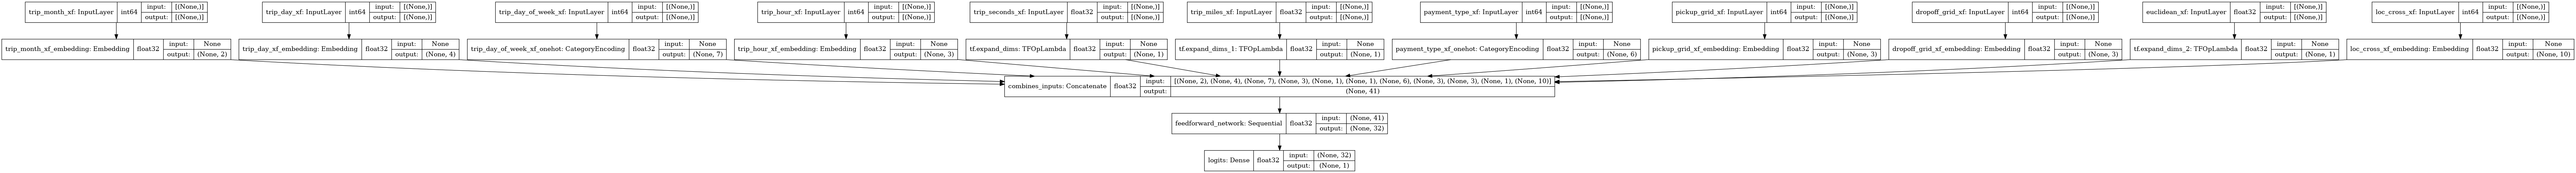

In [33]:
keras.utils.plot_model(
    classifier, 
    show_shapes=True, 
    show_dtype=True
)

In [34]:
classifier(input_features)

<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[0.16109464],
       [0.0334416 ],
       [0.05660707]], dtype=float32)>

### Train the model locally.

In [35]:
logging.getLogger().setLevel(logging.INFO)

hyperparams["learning_rate"] = 0.001
hyperparams["num_epochs"] = 5
hyperparams["batch_size"] = 512

vertex_ai.log_params(hyperparams)

In [37]:
classifier = trainer.train(
    train_data_dir=train_data_file_pattern,
    eval_data_dir=eval_data_file_pattern,
    tft_output_dir=TRANSFORM_ARTIFACTS_DIR,
    hyperparams=hyperparams,
    log_dir=LOG_DIR,
)

INFO:root:Loading tft output from gs://andy-1234-221921-mlops/chicago-taxi-tips/experiments/chicago-taxi-tips-classifier-v1-experiment/run-local-20210628180937/transform_artifacts
INFO:root:Model training started...
Epoch 1/5
8/8 [==============================] - 9s 1s/step - loss: 0.6861 - accuracy: 0.8908 - val_loss: 0.5849 - val_accuracy: 0.8945
Epoch 2/5
8/8 [==============================] - 0s 30ms/step - loss: 0.5598 - accuracy: 0.8865 - val_loss: 0.4699 - val_accuracy: 0.9062
Epoch 3/5
8/8 [==============================] - 1s 39ms/step - loss: 0.4560 - accuracy: 0.8982 - val_loss: 0.3747 - val_accuracy: 0.9219
Epoch 4/5
8/8 [==============================] - 0s 32ms/step - loss: 0.3764 - accuracy: 0.8908 - val_loss: 0.3217 - val_accuracy: 0.9004
Epoch 5/5
8/8 [==============================] - 0s 31ms/step - loss: 0.3170 - accuracy: 0.8869 - val_loss: 0.2802 - val_accuracy: 0.8926
INFO:root:Model training completed.


In [38]:
val_loss, val_accuracy = trainer.evaluate(
    model=classifier,
    data_dir=eval_data_file_pattern,
    raw_schema_location=RAW_SCHEMA_LOCATION,
    tft_output_dir=TRANSFORM_ARTIFACTS_DIR,
    hyperparams=hyperparams,
)

INFO:root:Loading raw schema from src/raw_schema/schema.pbtxt
INFO:root:Loading tft output from gs://andy-1234-221921-mlops/chicago-taxi-tips/experiments/chicago-taxi-tips-classifier-v1-experiment/run-local-20210628180937/transform_artifacts
INFO:root:Model evaluation started...
1/1 [==============================] - 0s 209ms/step - loss: 0.2614 - accuracy: 0.9082
INFO:root:Model evaluation completed.


In [39]:
vertex_ai.log_metrics(
    {"val_loss": val_loss, "val_accuracy": val_accuracy}
)

In [40]:
!tb-gcp-uploader --tensorboard_resource_name={tensorboard_resource_name} \
  --logdir={LOG_DIR} \
  --experiment_name={EXPERIMENT_NAME} --one_shot=True

2021-06-28 18:18:48.978288: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
INFO:tensorboard:Creating experiment
I0628 18:18:50.853662 140204983535424 uploader.py:262] Creating experiment
View your Tensorboard at https://us-central1.tensorboard.googleusercontent.com/experiment/projects+759209241365+locations+us-central1+tensorboards+438573198087290880+experiments+chicago-taxi-tips-classifier-v1-experiment
INFO:tensorboard:Starting an upload cycle
I0628 18:18:51.223268 140204983535424 uploader.py:326] Starting an upload cycle
INFO:tensorboard:Starting logdir traversal of gs://andy-1234-221921-mlops/chicago-taxi-tips/experiments/chicago-taxi-tips-classifier-v1-experiment/run-local-20210628180937/logs
I0628 18:18:51.223489 140204983535424 logdir_loader.py:65] Starting logdir traversal of gs://andy-1234-221921-mlops/chicago-taxi-tips/experiments/chicago-taxi-tips-classifier-v1-experiment/run-local-20210628180937/logs
INF

### Export the trained model in SavedModel format

In [41]:
saved_model_dir = os.path.join(EXPORT_DIR)

exporter.export_serving_model(
    classifier=classifier,
    serving_model_dir=saved_model_dir,
    raw_schema_location=RAW_SCHEMA_LOCATION,
    tft_output_dir=TRANSFORM_ARTIFACTS_DIR,
)

Exception ignored in: <function CapturableResourceDeleter.__del__ at 0x7fcfa49b7050>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/training/tracking/tracking.py", line 208, in __del__
    self._destroy_resource()
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/eager/def_function.py", line 828, in __call__
    result = self._call(*args, **kwds)
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/eager/def_function.py", line 871, in _call
    self._initialize(args, kwds, add_initializers_to=initializers)
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/eager/def_function.py", line 726, in _initialize
    *args, **kwds))
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/eager/function.py", line 2969, in _get_concrete_function_internal_garbage_collected
    graph_function, _ = self._maybe_define_function(args, kwargs)
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/p

INFO:root:Model export started...
INFO:tensorflow:Assets written to: gs://andy-1234-221921-mlops/chicago-taxi-tips/experiments/chicago-taxi-tips-classifier-v1-experiment/run-local-20210628180937/model/assets
INFO:tensorflow:Assets written to: gs://andy-1234-221921-mlops/chicago-taxi-tips/experiments/chicago-taxi-tips-classifier-v1-experiment/run-local-20210628180937/model/assets
INFO:root:Model export completed.


### Inspect model serving signatures

In [42]:
!saved_model_cli show --dir={saved_model_dir} --tag_set=serve --signature_def=serving_tf_example

2021-06-28 18:19:33.197605: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
The given SavedModel SignatureDef contains the following input(s):
  inputs['examples'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      name: serving_tf_example_examples:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['probabilities'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: StatefulPartitionedCall_41:0
Method name is: tensorflow/serving/predict


In [43]:
!saved_model_cli show --dir={saved_model_dir} --tag_set=serve --signature_def=serving_default

2021-06-28 18:19:45.591231: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
The given SavedModel SignatureDef contains the following input(s):
  inputs['dropoff_grid'] tensor_info:
      dtype: DT_STRING
      shape: (-1, 1)
      name: serving_default_dropoff_grid:0
  inputs['euclidean'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: serving_default_euclidean:0
  inputs['loc_cross'] tensor_info:
      dtype: DT_STRING
      shape: (-1, 1)
      name: serving_default_loc_cross:0
  inputs['payment_type'] tensor_info:
      dtype: DT_STRING
      shape: (-1, 1)
      name: serving_default_payment_type:0
  inputs['pickup_grid'] tensor_info:
      dtype: DT_STRING
      shape: (-1, 1)
      name: serving_default_pickup_grid:0
  inputs['trip_day'] tensor_info:
      dtype: DT_INT64
      shape: (-1, 1)
      name: serving_default_trip_day:0
  inputs['trip_day_of_week'] tensor_info:
      dtype: DT_INT

### Test the exported model

In [44]:
serving_model = tf.saved_model.load(saved_model_dir)

In [45]:
file_names = tf.data.TFRecordDataset.list_files(EXPORTED_DATA_PREFIX + '/data-*.tfrecord')
for batch in tf.data.TFRecordDataset(file_names).batch(3).take(1):
    predictions = serving_model.signatures['serving_tf_example'](batch)
    for key in predictions:
        print(f"{key}: {predictions[key]}")

probabilities: [[0.1373589 ]
 [0.11954904]
 [0.15857667]]


In [46]:
import tensorflow_data_validation as tfdv
from tensorflow_transform.tf_metadata import schema_utils

raw_schema = tfdv.load_schema_text(RAW_SCHEMA_LOCATION)
raw_feature_spec = schema_utils.schema_as_feature_spec(raw_schema).feature_spec

In [47]:
instance = {
    "dropoff_grid": "POINT(-87.6 41.9)",
    "euclidean": 2064.2696,
    "loc_cross": "",
    "payment_type": "Credit Card",
    "pickup_grid": "POINT(-87.6 41.9)",
    "trip_miles": 1.37,
    "trip_day": 12,
    "trip_hour": 6,
    "trip_month": 2,
    "trip_day_of_week": 4,
    "trip_seconds": 555,
}

for feature_name in instance:
    dtype = raw_feature_spec[feature_name].dtype
    instance[feature_name] = tf.constant([[instance[feature_name]]], dtype)

In [48]:
predictions = serving_model.signatures['serving_default'](**instance)
for key in predictions:
    print(f"{key}: {predictions[key].numpy()}")

scores: [[0.38773873 0.6122613 ]]
classes: [[b'tip<20%' b'tip>=20%']]


## Start a new `Vertex Experiment` run

In [50]:
vertex_ai.init(
    project=PROJECT_ID,
    staging_bucket=BUCKET,
    experiment=EXPERIMENT_NAME)

run_id = f"run-gcp-{datetime.now().strftime('%Y%m%d%H%M%S')}"
vertex_ai.start_run(run_id)

EXPERIMENT_RUN_DIR = os.path.join(EXPERIMENT_ARTIFACTS_DIR, EXPERIMENT_NAME, run_id)
print("Experiment run directory:", EXPERIMENT_RUN_DIR)

INFO:root:Resource chicago-taxi-tips-classifier-v1-experiment-run-gcp-20210628182147 not found.
INFO:root:Creating Resource chicago-taxi-tips-classifier-v1-experiment-run-gcp-20210628182147
INFO:root:Resource chicago-taxi-tips-classifier-v1-experiment-run-gcp-20210628182147-metrics not found.
INFO:root:Creating Resource chicago-taxi-tips-classifier-v1-experiment-run-gcp-20210628182147-metrics
Experiment run directory: gs://andy-1234-221921-mlops/chicago-taxi-tips/experiments/chicago-taxi-tips-classifier-v1-experiment/run-gcp-20210628182147


## 3. Submit a data processing job to `Dataflow`

In [51]:
EXPORTED_DATA_PREFIX = os.path.join(EXPERIMENT_RUN_DIR, 'exported_data')
TRANSFORMED_DATA_PREFIX = os.path.join(EXPERIMENT_RUN_DIR, 'transformed_data')
TRANSFORM_ARTIFACTS_DIR = os.path.join(EXPERIMENT_RUN_DIR, 'transform_artifacts')

In [56]:
ML_USE = 'UNASSIGNED'
LIMIT = 1000000
raw_data_query = datasource_utils.get_training_source_query(
    project=PROJECT_ID, 
    region=REGION, 
    dataset_display_name=DATASET_DISPLAY_NAME, 
    ml_use=ML_USE, 
    limit=LIMIT
)

args = {
    'runner': 'DataflowRunner',
    'raw_data_query': raw_data_query,
    'exported_data_prefix': EXPORTED_DATA_PREFIX,
    'transformed_data_prefix': TRANSFORMED_DATA_PREFIX,
    'transform_artifact_dir': TRANSFORM_ARTIFACTS_DIR,
    'write_raw_data': False,
    'temporary_dir': os.path.join(WORKSPACE, 'tmp'),
    'gcs_location': os.path.join(WORKSPACE, 'bq_tmp'),
    'project': PROJECT_ID,
    'region': REGION,
    'setup_file': './setup.py'
}

In [57]:
vertex_ai.log_params(args)

In [59]:
logging.getLogger().setLevel(logging.ERROR)

print("Data preprocessing started...")
etl.run_transform_pipeline(args)
print("Data preprocessing completed.")

Data preprocessing started...


KeyboardInterrupt: 

In [ ]:
!gsutil ls {EXPERIMENT_RUN_DIR}

## 4. Submit a custom training job to `Vertex AI`

In [ ]:
LOG_DIR = os.path.join(EXPERIMENT_RUN_DIR, 'logs')
EXPORT_DIR = os.path.join(EXPERIMENT_RUN_DIR, 'model')

### Test the training task locally

In [ ]:
!python -m src.model_training.task \
    --model-dir={EXPORT_DIR} \
    --log-dir={LOG_DIR} \
    --train-data-dir={TRANSFORMED_DATA_PREFIX}/train/* \
    --eval-data-dir={TRANSFORMED_DATA_PREFIX}/eval/*  \
    --tft-output-dir={TRANSFORM_ARTIFACTS_DIR} \
    --num-epochs=5 \
    --hidden-units=32,32 \
    --experiment-name={EXPERIMENT_NAME} \
    --run-name={run_id} \
    --project={PROJECT_ID} \
    --region={REGION} \
    --staging-bucket={BUCKET}

### Prepare the training package

In [ ]:
TRAINER_PACKAGE_DIR = os.path.join(WORKSPACE, 'trainer_packages')
TRAINER_PACKAGE_NAME = f'{MODEL_DISPLAY_NAME}_trainer'
print("Trainer package upload location:", TRAINER_PACKAGE_DIR)

In [ ]:
!rm -r src/__pycache__/
!rm -r src/.ipynb_checkpoints/
!rm -r src/raw_schema/.ipynb_checkpoints/
!rm -f {TRAINER_PACKAGE_NAME}.tar {TRAINER_PACKAGE_NAME}.tar.gz

!mkdir {TRAINER_PACKAGE_NAME}

!cp setup.py {TRAINER_PACKAGE_NAME}/
!cp -r src {TRAINER_PACKAGE_NAME}/
!tar cvf {TRAINER_PACKAGE_NAME}.tar {TRAINER_PACKAGE_NAME}
!gzip {TRAINER_PACKAGE_NAME}.tar
!gsutil cp {TRAINER_PACKAGE_NAME}.tar.gz {TRAINER_PACKAGE_DIR}/
!rm -r {TRAINER_PACKAGE_NAME}
!rm -r {TRAINER_PACKAGE_NAME}.tar.gz

### Prepare the training job

In [ ]:
TRAIN_RUNTIME = 'tf-cpu.2-4'
TRAIN_IMAGE = f"gcr.io/cloud-aiplatform/training/{TRAIN_RUNTIME}:latest"
print("Training image:", TRAIN_IMAGE)

In [ ]:
num_epochs = 10
learning_rate = 0.001
hidden_units = "64,64"

trainer_args = [
    f'--train-data-dir={TRANSFORMED_DATA_PREFIX + "/train/*"}',
    f'--eval-data-dir={TRANSFORMED_DATA_PREFIX + "/eval/*"}',
    f'--tft-output-dir={TRANSFORM_ARTIFACTS_DIR}',
    f'--num-epochs={num_epochs}',
    f'--learning-rate={learning_rate}',
    f'--project={PROJECT}',
    f'--region={REGION}',
    f'--staging-bucket={BUCKET}',
    f'--experiment-name={EXPERIMENT_NAME}'
]

In [ ]:
package_uri = os.path.join(TRAINER_PACKAGE_DIR, f'{TRAINER_PACKAGE_NAME}.tar.gz')

training_spec = [
    {
        "replica_count": 1,
        "machine_spec": {
            "machine_type": 'n1-standard-4',
            "accelerator_count": 0
    },
        "python_package_spec": {
            "executor_image_uri": TRAIN_IMAGE,
            "package_uris": [package_uri],
            "python_module": "src.model_training.task",
            "args": trainer_args,
        }
    }
]

### Submit the training job

In [ ]:
print("Submitting a custom training job...")

job_display_name = f"{TRAINER_PACKAGE_NAME}_{datetime.now().strftime('%Y%m%d%H%M%S')}"

custom_job = {
    "display_name": job_display_name,
    "job_spec": {
        "worker_pool_specs": training_spec,
        "base_output_directory": {"output_uri_prefix": EXPERIMENT_RUN_DIR},
        "service_account": SERVICE_ACCOUNT,
        "tensorboard": tensorboard_resource_name,
    }
}

job_client_beta = vertex_ai_beta.JobServiceClient(
    client_options={"api_endpoint": f"{REGION}-aiplatform.googleapis.com"}
)

job = job_client_beta.create_custom_job(
    parent=PARENT,
    custom_job=custom_job
)

print(f"Job {job.name} submitted.")

### Monitor job state

In [ ]:
while True:
    response = job_client_beta.get_custom_job(name=job.name)
    if response.state.name == 'JOB_STATE_SUCCEEDED':
        print("Training job completed. - Training Elapsed Time:", response.update_time - response.create_time)
        print("Training Job Time:", response.end_time - response.start_time)
        break
    elif response.state.name == 'JOB_STATE_FAILED':
        print("Training job failed!")
        break
    else:
        print(f"Training job state is: {response.state.name}.")
    time.sleep(60)

## 5. Upload exported model to Vertex AI Models

In [ ]:
!gsutil ls {EXPORT_DIR}

### Generate the Explaination metadata

In [ ]:
explanation_config = features.generate_explanation_config()
explanation_config

### Upload model

In [ ]:
SERVING_RUNTIME='tf2-cpu.2-4'
SERVING_IMAGE = f"gcr.io/cloud-aiplatform/prediction/{SERVING_RUNTIME}:latest"
print("Serving image:", SERVING_IMAGE)

In [ ]:
explanation_metadata = vertex_ai.explain.ExplanationMetadata(
    inputs=explanation_config["inputs"],
    outputs=explanation_config["outputs"],
)
explanation_parameters = vertex_ai.explain.ExplanationParameters(
    explanation_config["params"]
)

vertex_model = vertex_ai.Model.upload(
    display_name=MODEL_DISPLAY_NAME,
    artifact_uri=EXPORT_DIR,
    serving_container_image_uri=SERVING_IMAGE,
    parameters_schema_uri=None,
    instance_schema_uri=None,
    explanation_metadata=explanation_metadata,
    explanation_parameters=explanation_parameters,
)

In [ ]:
vertex_model.gca_resource

## 6. Exract experiment run parameters

In [ ]:
experiment_df = vertex_ai.get_experiment_df()
experiment_df = experiment_df[experiment_df.experiment_name == EXPERIMENT_NAME]
experiment_df.T

In [ ]:
print("Vertex AI Experiments:")
print(
    f"https://console.cloud.google.com/vertex-ai/locations{REGION}/experiments/{EXPERIMENT_NAME}/metrics?project={PROJECT}"
)